# Example: Large TIF H3 Zonal Statistics

> Use various Spatial-Utils functions, executed on DBR 15.4 LTS.

__Notes:__

* This only focuses on a single large GeoTIFF of 1.5GB, to help make this a more portable example.
  * the fact that it is implemented to be distributed may not be as apparent in the first section (prior to subdividing). 
* A cluster with a single worker is sufficient, recomment having a RAM-CPU ratio of 8GB, e.g. 4CPUs with 32GB RAM. 
* Given the size of the data (projecting, tessellating, and rendering), recommend using an Assigned cluster for this ... potentially could use new high-memory Serverless but not necessarily recommending.

https://github.com/databrickslabs/mosaic/blob/spatial-utils-v1/examples/raster/polars/spatial-utils-raster-h3-polars.ipynb

---
__Author:__ Michael Johns <mjohns@databricks.com> | _Last Updated:_ 20 DEC 2024

## Setup

### Imports

In [0]:
%pip install -U "databricks-spatial[raster] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

In [0]:
dbutils.library.restartPython()

In [0]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio

from rasterio.plot import show as rasterio_show

In [0]:
# SPATIAL-UTILS @ UTILS
from spatial import Utils

# SPATIAL-UTILS @ VIZ
from spatial.viz.helpers import *

# SPATIAL-UTILS @ RASTER
# - registers UDFs
# - provides PolarsUtils and RioUtils
from spatial.raster import *

# SPATIAL-UTILS @ H3
# - provides H3Utils
from spatial.grid.h3 import *

### Data

In [0]:
import os

dir_in = "/Volumes/geospatial_docs/large_tifs/data/dist/orig"
dir_wgs84 = "/Volumes/geospatial_docs/large_tifs/data/dist/wgs84"
dir_h3 = "/Volumes/geospatial_docs/large_tifs/data/dist/h3"

os.makedirs(dir_in, exist_ok=True)
os.makedirs(dir_wgs84, exist_ok=True)
os.makedirs(dir_h3, exist_ok=True)

os.environ['DIR_IN'] = dir_in
os.environ['DIR_WGS84'] = dir_wgs84
os.environ['DIR_H3'] = dir_h3

In [0]:
ls -lh $DIR_IN

total 1.5G
-rwxrwxrwx 1 nobody nogroup 1.5G Oct 30 19:18 Time_Extract_CO_081423.tif*


## Distributed

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

In [0]:
def h3_avg_to_pandas(fuse_path:str, h3_res:int) -> pd.DataFrame:
  """
  Purpose built for this use case.
  - Uses spatial-utils
  - returns a pandas DataFrame; 
    if geo=True then GeoDataFrame is returned, 
    but the default is False
  """
  from spatial import Utils
  from spatial.raster.rasterio import RioUtils
  import numpy as np
  import os
  import polars as pl
  import rasterio
  
  path = Utils.path_as_fuse(fuse_path)
  ds = rasterio.open(path)
  
  return RioUtils.try_dataset_to_h3_pdf(
    ds, h3_res, band_idx=1, nodata_value=np.NAN, compact=False, val_type=np.float32
  )

In [0]:
def h3_avg_pandas_map(iterator):
  """
  Purpose built for this use case.
  """
  for pdf in iterator:
    for index, row in pdf.iterrows():
      path = row['path_4326']
      res = row['h3_res']
      yield h3_avg_to_pandas(path, res)

### [1] Create Spark DataFrame

In [0]:
df_in = spark.createDataFrame(dbutils.fs.ls(dir_in))
df_in.display()

path name size modificationTime dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/orig/Time_Extract_CO_081423.tif Time_Extract_CO_081423.tif 1521510698 1730315902000

### [2] Reproject to WGS84

In [0]:
spark.catalog.clearCache()

# define the output paths
df_4326 = (
  df_in
    .withColumn(
      "path_4326",
      F.concat(F.lit(dir_wgs84), F.lit("/"), "name")
    )
)

# perform the reproject
(
  df_4326
    .select(reproject_tif_4326_udf("path", "path_4326").alias("path_4326")) # <- SPATIAL-UTILS
    .cache()
)
print(f"count? {df_4326.count()}")
df_4326.display()

count? 1


path name size modificationTime path_4326 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/orig/Time_Extract_CO_081423.tif Time_Extract_CO_081423.tif 1521510698 1730315902000 /Volumes/geospatial_docs/large_tifs/data/dist/wgs84/Time_Extract_CO_081423.tif

In [0]:
ls -lh $DIR_WGS84

total 1.7G
-rwxrwxrwx 1 nobody nogroup 1.7G Nov 12 21:41 Time_Extract_CO_081423.tif*


In [0]:
ds_4326 = rasterio.open(f"{dir_wgs84}/Time_Extract_CO_081423.tif")
print(f"bounds -> {ds_4326.bounds}")
print(f"shape -> {ds_4326.shape}")
print(f"meta -> {ds_4326.meta}")

bounds -> BoundingBox(left=-76.01576006846206, bottom=38.635305815823415, right=-75.69816383897631, top=39.145838240228244)
shape -> (26874, 16718)
meta -> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 16718, 'height': 26874, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8997262201563854e-05, 0.0, -76.01576006846206,
       0.0, -1.8997262201563854e-05, 39.145838240228244)}


h_px, w_px -> 26874, 16718
fig_scale -> [ 8.359 13.437]


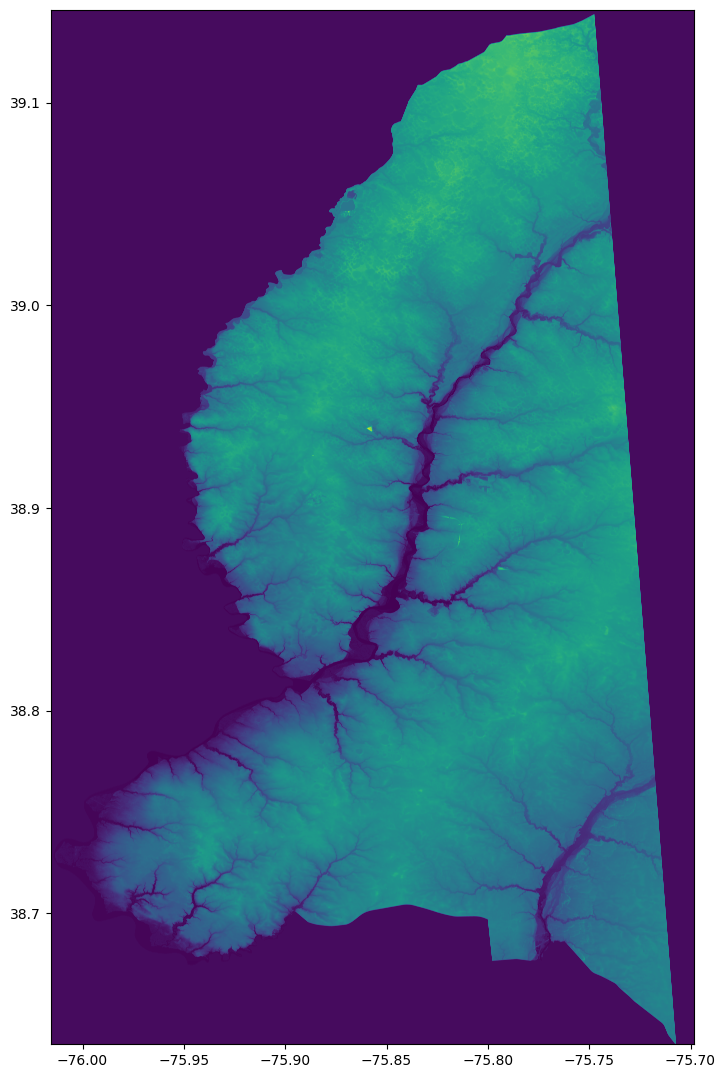

<Axes: >

In [0]:
fig = RioUtils.figsize_scale(ds_4326, scale_factor=.05) # <- 5% (SPATIAL-UTILS)
rasterio_show(ds_4326)

In [0]:
try:
  del ds_4326
except:
  pass

### [3] Tessellate with H3

#### What is the Nearest H3 Resolution?

> Based on pixel spatial resolution. We don't have to go all the way to 15, but that would be most lossless.

In [0]:
# can skip the projection, 
# - since handled previously in the notebook
df_4326 = (
  df_in
    .withColumn(
      "path_4326",
      F.concat(F.lit(dir_wgs84), F.lit("/"), "name")
    )
)

# identify nearest h3 res to raster spatial res
display(
  df_4326
    .withColumn(
      "h3_nearest_res",
      nearest_h3_res_udf("path_4326") # <- SPATIAL-UTILS
    )
    .select("path_4326", "h3_nearest_res")
  .limit(1)
)

path_4326 h3_nearest_res /Volumes/geospatial_docs/large_tifs/data/dist/wgs84/Time_Extract_CO_081423.tif 15

#### Schema for the operation

> Not shown but this came from running a single example.

In [0]:
schema_h3 = StructType([
  StructField('value', DoubleType(), True),
  StructField('cellid', LongType(), True),
  StructField('filename', StringType(), True)
])

__Helpers Used Below__

In [0]:
def handle_viz(df):
  """
  Uses spatial-utils.
  """
  # -- SPATIAL-UTILS --
  pdf = H3Utils.h3_to_str_pdf(
    df.toPandas(), 'cellid', new_h3_str_col='cellid_str', drop_h3_int_col=True
  )
  gdf = H3Utils.h3_pdf_to_gdf(pdf, 'cellid_str')
  render_gdf(gdf, val_col='value') 

In [0]:
def handle_res(
  df_path_4326, res, do_info=True, do_viz=True, clear_cache=True, do_display=True, display_limit=3):
  """
  Uses spatial-utils.
  - expects df_path_4326 to have column 'path_4326'.
  """
  if do_info:
    H3Utils.print_res_info(res) 
  try:
    df = (
      df_path_4326
        .withColumn("h3_res", F.lit(res))
        .mapInPandas(
          h3_avg_pandas_map,
          schema_h3
        )
      .cache() # <- avoid recompute
    )
    if do_info:
      print(f"count? {df.count():,}, all unique? {df.groupBy('filename','cellid').count().count() == df.count()}")
    if do_display:
      df.limit(display_limit).display()
    if do_viz:
      handle_viz(df) 
    return df
  finally:
    if clear_cache:
      df.unpersist()

#### Combining at H3 Res=7

area in meters? 5,161,293.2
edge length in meters? 1,220.629759
count? 309, all unique? True


value cellid filename 65.94471740722656 608736729523814399 Time_Extract_CO_081423.tif 42.5518913269043 608736415001346047 Time_Extract_CO_081423.tif 45.966102600097656 608736411192918015 Time_Extract_CO_081423.tif

DataFrame[value: double, cellid: bigint, filename: string]

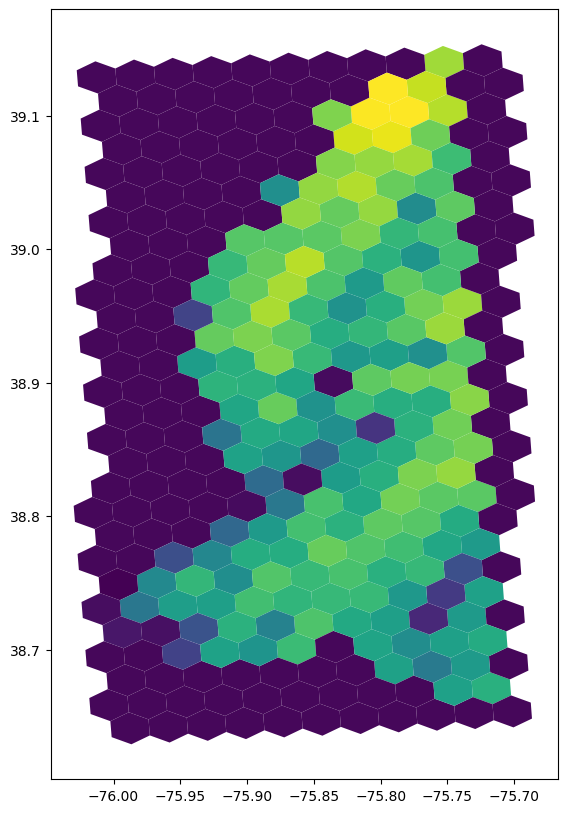

In [0]:
handle_res(df_4326, 7)

#### Combining at H3 Res=9

area in meters? 105,332.5
edge length in meters? 174.37566800000002
count? 15,262, all unique? True


value cellid filename 34.97174072265625 617743614468423679 Time_Extract_CO_081423.tif 7.361097812652588 617743614057381887 Time_Extract_CO_081423.tif 54.99958419799805 617743614589009919 Time_Extract_CO_081423.tif

DataFrame[value: double, cellid: bigint, filename: string]

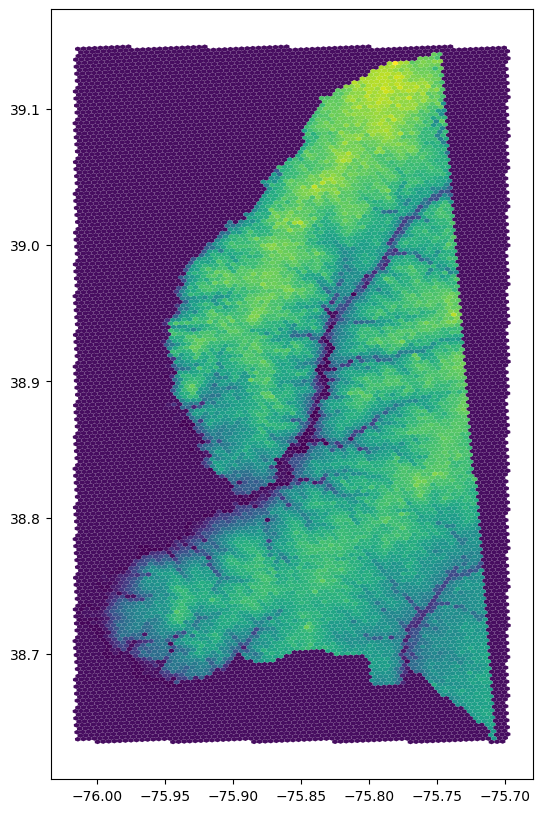

In [0]:
handle_res(df_4326, 9)

## What if we Subdivide the raster?

> Then we *can* get all the way to resolution 15 (but don't have to, unless we want).

In [0]:
import os

dir_subdiv = "/Volumes/geospatial_docs/large_tifs/data/dist/subdiv"
os.makedirs(dir_subdiv, exist_ok=True)
os.environ['DIR_SUBDIV'] = dir_subdiv

In [0]:
%sh
# -- uncomment to clean-up (avoid confusion)
#rm -f $DIR_SUBDIV/*
#ls -lh $DIR_SUBDIV

In [0]:
df_4326 = (
  df_in
    .withColumn(
      "path_4326",
      F.concat(F.lit(dir_wgs84), F.lit("/"), "name")
    )
)

In [0]:
# -- uncomment to re-run
# - takes about 4 minutes
# spark.catalog.clearCache()

# df_subdiv = (
#   df_4326
#     .withColumn(
#       "subdiv_paths",
#       subdivide_tif_mb_udf("path_4326", F.lit(dir_subdiv), F.lit(4)) # <- SPATIAL-UTILS
#     )
#   .cache() # <- avoid recompute
# )

# print(f"count? {df_subdiv.count()}")
# df_subdiv.display()

In [0]:
# %sh ls -lh $DIR_SUBDIV

In [0]:
split_files = dbutils.fs.ls(dir_subdiv)
print(f"num split_files? {len(split_files):,}")

num split_files? 441


In [0]:
spark.catalog.clearCache()

df_sd = (
  spark.createDataFrame(split_files)
    .withColumnRenamed("path", "path_4326")
)
print(f"count? {df_sd.count():,}")
df_sd.limit(10).display()

count? 441


path_4326 name size modificationTime dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_0.tif Time_Extract_CO_081423-0_0.tif 4084846 1734761347000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_1.tif Time_Extract_CO_081423-0_1.tif 4084846 1734761348000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_10.tif Time_Extract_CO_081423-0_10.tif 4084846 1734761355000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_11.tif Time_Extract_CO_081423-0_11.tif 4084846 1734761356000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_12.tif Time_Extract_CO_081423-0_12.tif 4084846 1734761357000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_13.tif Time_Extract_CO_081423-0_13.tif 4084846 1734761357000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_14.tif Time_Extract_CO_081423-0_14.tif 4084846 1734761358000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_15.tif Time_Extract_CO_081423-0_15.tif 4084846 1734761358000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_16.tif Time_Extract_CO_081423-0_16.tif 4081658 1734761359000 dbfs:/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-0_17.tif Time_Extract_CO_081423-0_17.tif 4084846 1734761360000

### Resolution 11 [Show ALL Sub-Divided]

> Rendering takes a few minutes ... if you skip rendering, then much faster to just generate data. __Notice: how well the data approximates the original 1.5GB raster.__

area in meters? 2,149.6000000000004
edge length in meters? 24.910561
count? 747,878, all unique? True


value cellid filename 0.0 626750800861372415 Time_Extract_CO_081423-0_0.tif 0.0 626750800861380607 Time_Extract_CO_081423-0_0.tif 0.0 626750800861597695 Time_Extract_CO_081423-0_0.tif

DataFrame[value: double, cellid: bigint, filename: string]

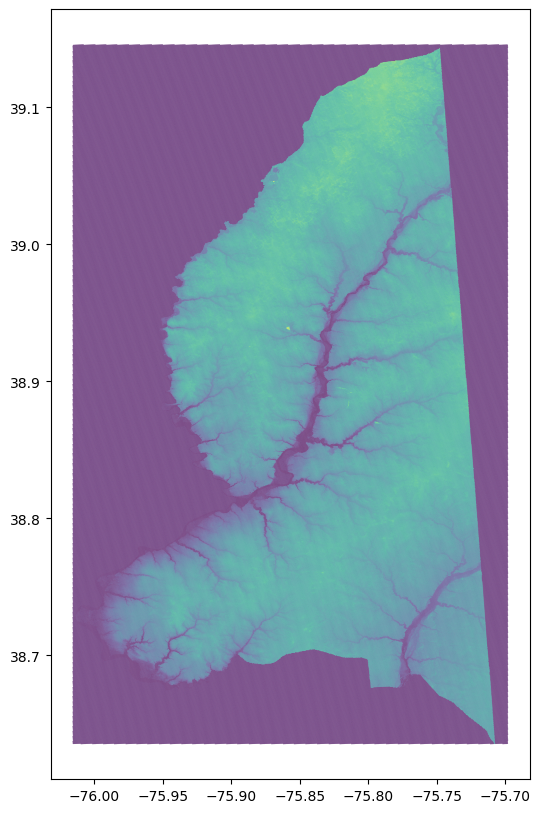

In [0]:
handle_res(df_sd, 11)

###  Show Single Split File

> 1 file out of the 441 subdivided files.

In [0]:
c, r = (8,8)
split1_path = f"{dir_subdiv}/Time_Extract_CO_081423-{c}_{r}.tif"
split1_path

'/Volumes/geospatial_docs/large_tifs/data/dist/subdiv/Time_Extract_CO_081423-8_8.tif'

In [0]:
ds_split1 = rasterio.open(split1_path)
print(f"bounds -> {ds_split1.bounds}")
print(f"shape -> {ds_split1.shape}")
print(f"meta -> {ds_split1.meta}")

bounds -> BoundingBox(left=-75.8947475082381, bottom=38.92698977966623, right=-75.87962568752565, top=38.95130627528423)
shape -> (1280, 796)
meta -> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 796, 'height': 1280, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8997262201563854e-05, 0.0, -75.8947475082381,
       0.0, -1.8997262201563854e-05, 38.95130627528423)}


h_px, w_px -> 1280, 796
fig_scale -> [ 7.96 12.8 ]


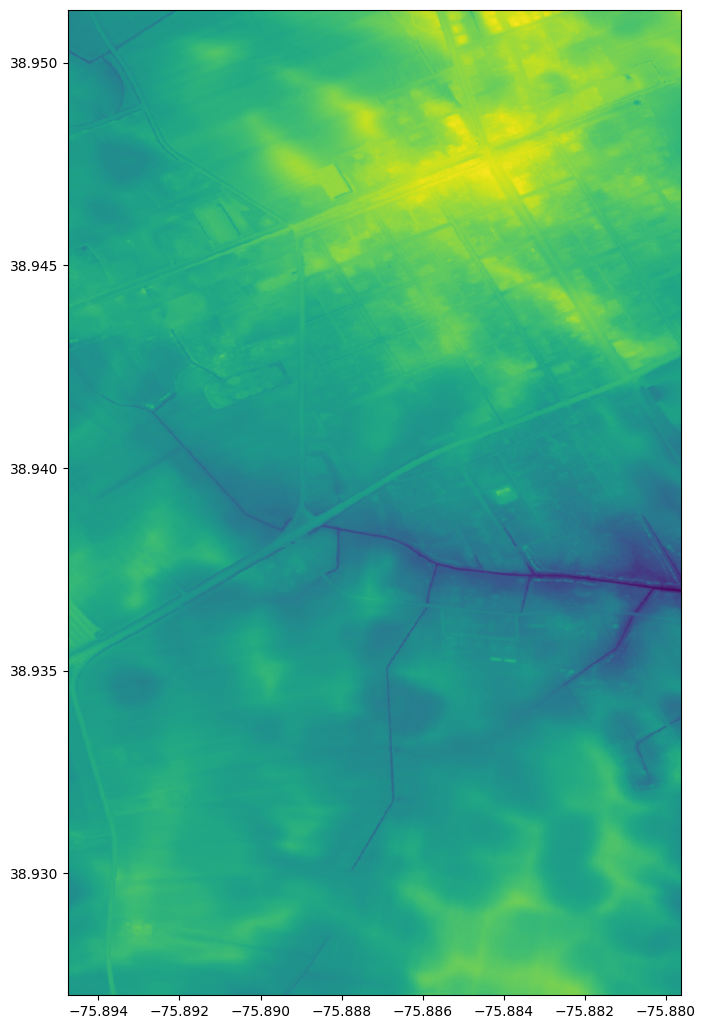

<Axes: >

In [0]:
fig = RioUtils.figsize_scale(ds_split1, scale_factor=1.0) # <- SPATIAL-UTILS
rasterio_show(ds_split1)

In [0]:
try:
  del ds_split1
except:
  pass

### Resolution 12 [Single Sub-Divided]

area in meters? 307.09999999999997
edge length in meters? 9.415526
count? 11,854, all unique? True


value cellid filename 55.05897521972656 631254411981041151 Time_Extract_CO_081423-8_8.tif 57.579795837402344 631254412490237439 Time_Extract_CO_081423-8_8.tif 63.09001159667969 631254412491590143 Time_Extract_CO_081423-8_8.tif

DataFrame[value: double, cellid: bigint, filename: string]

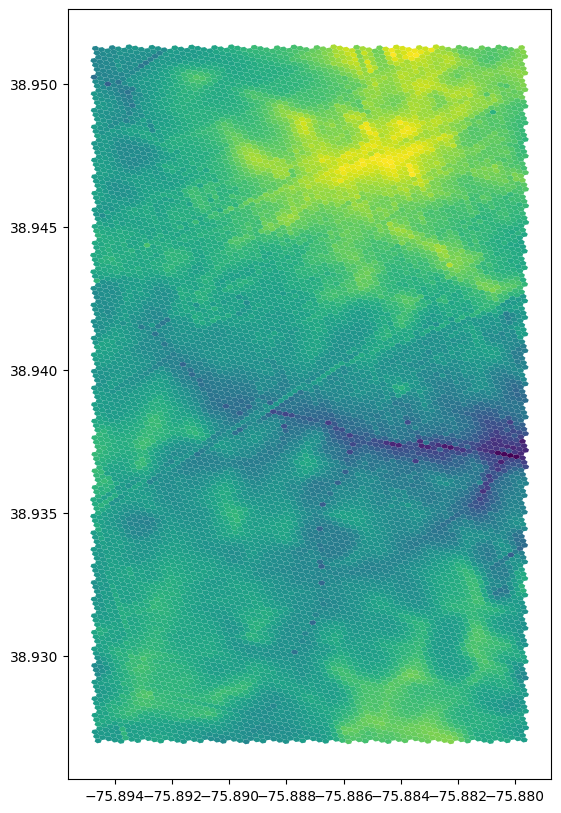

In [0]:
handle_res(df_sd.filter(f"path_4326 = 'dbfs:{split1_path}'"), 12)

### Resolution 13 [Single Sub-Divided]

area in meters? 43.900000000000006
edge length in meters? 3.559893
count? 82,960, all unique? True


value cellid filename 54.58635330200195 635758013376572799 Time_Extract_CO_081423-8_8.tif 54.05314636230469 635758011611491199 Time_Extract_CO_081423-8_8.tif 54.3349494934082 635758011609461119 Time_Extract_CO_081423-8_8.tif

DataFrame[value: double, cellid: bigint, filename: string]

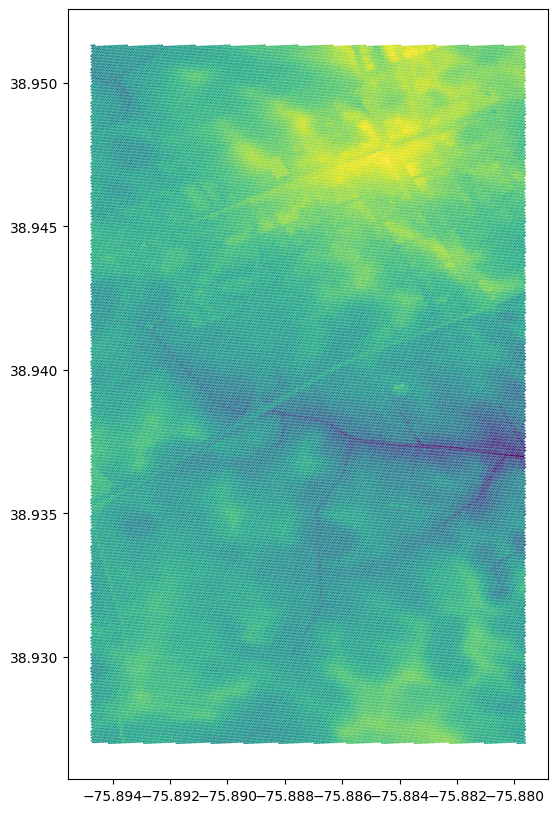

In [0]:
handle_res(df_sd.filter(f"path_4326 = 'dbfs:{split1_path}'"), 13)

### Resolution 14 [Single Sub-Divided]

> For this fine-grained resolution, while the calculation of the ~580K cellids + values for the raster only takes ~9s, rendering by h3 cellid can take on the order of 1.5 minutes.

area in meters? 6.3
edge length in meters? 1.348575
count? 580,737, all unique? True


value cellid filename 55.67047882080078 640261611746539607 Time_Extract_CO_081423-8_8.tif 59.03361892700195 640261611741532271 Time_Extract_CO_081423-8_8.tif 55.91145324707031 640261611249353479 Time_Extract_CO_081423-8_8.tif

DataFrame[value: double, cellid: bigint, filename: string]

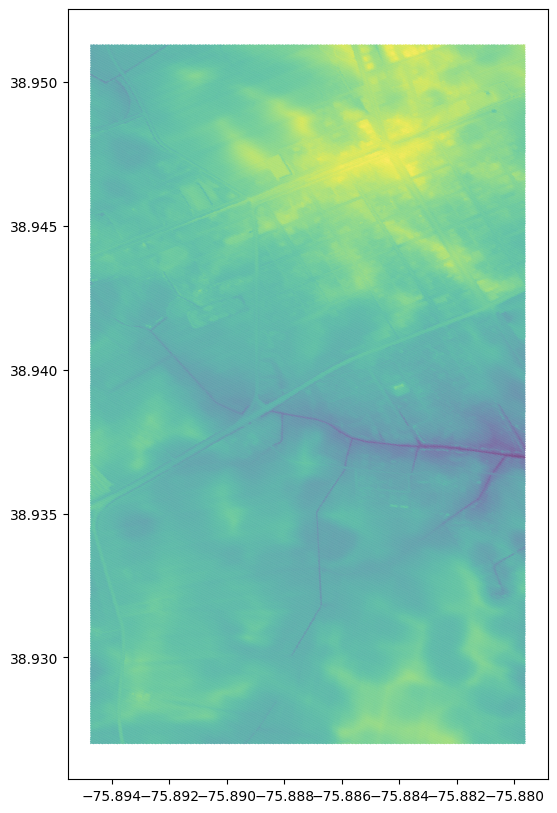

In [0]:
handle_res(df_sd.filter(f"path_4326 = 'dbfs:{split1_path}'"), 14)

### Resolution 15 [Single Sub-Divided]

> For this very fine-grained resolution, while the calculation of the ~4M cellids + values for the raster only takes ~15s, rendering can take on the order of 10 minutes.

area in meters? 0.8999999999999999
edge length in meters? 0.509713
count? 4,065,167, all unique? True


value cellid filename 60.312225341796875 644765212571546513 Time_Extract_CO_081423-8_8.tif 60.312225341796875 644765212571546515 Time_Extract_CO_081423-8_8.tif 60.312225341796875 644765212571546520 Time_Extract_CO_081423-8_8.tif

DataFrame[value: double, cellid: bigint, filename: string]

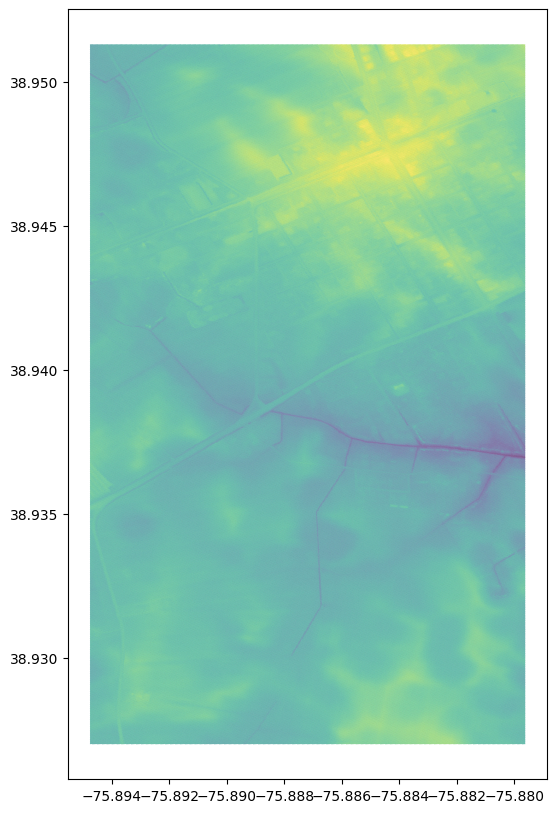

In [0]:
handle_res(df_sd.filter(f"path_4326 = 'dbfs:{split1_path}'"), 15)

__Notice that the above h3 @ resolution 15 is "very" close to the original image.__